# <center><h1>Sistemas de información. Práctica 1</h1></center>

<center><h2>Xuquiang Liu Xu, Óscar Lozano Pérez, Iván García Lozano</h2></center>

<h3>Ejercicio 1</h3><h4 style='text-align: justify;'>En este primer ejercicio, el grupo deberá desarrollar el modelado del proceso de negocio descrito anteriormente usado las dos notaciones vistas en teoría: Business Process Modeling Notation (1.5 punto) y Unified Modeling Language (1.5 punto)</h4>

<h3>Modelo UML</h3>

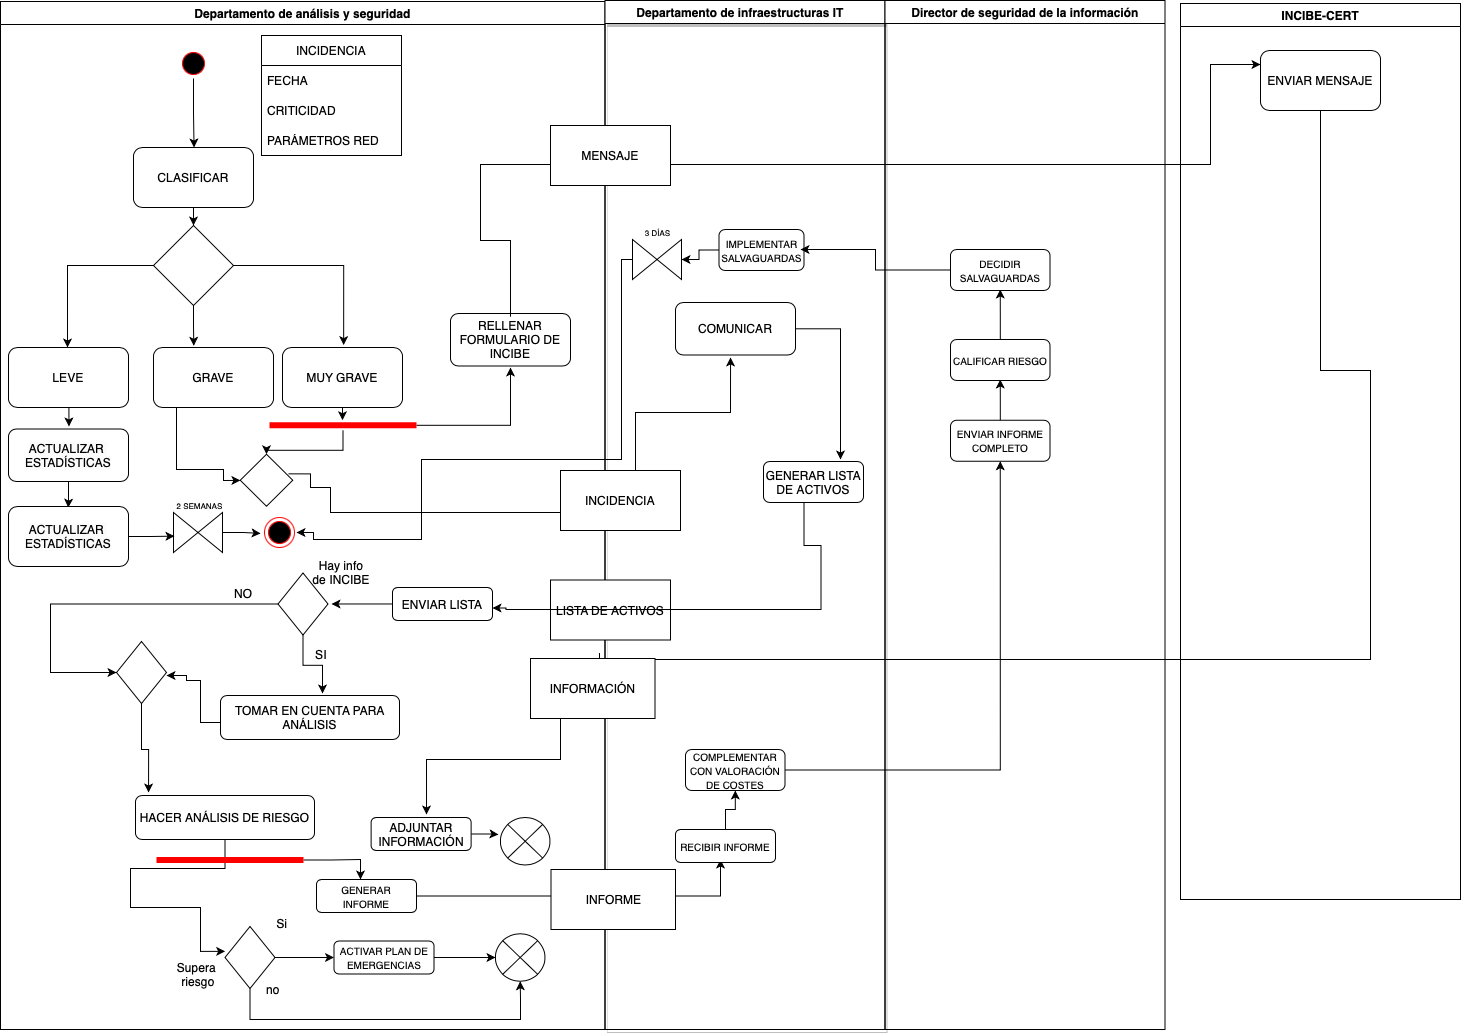

<h3>Modelo BPMN</h3>

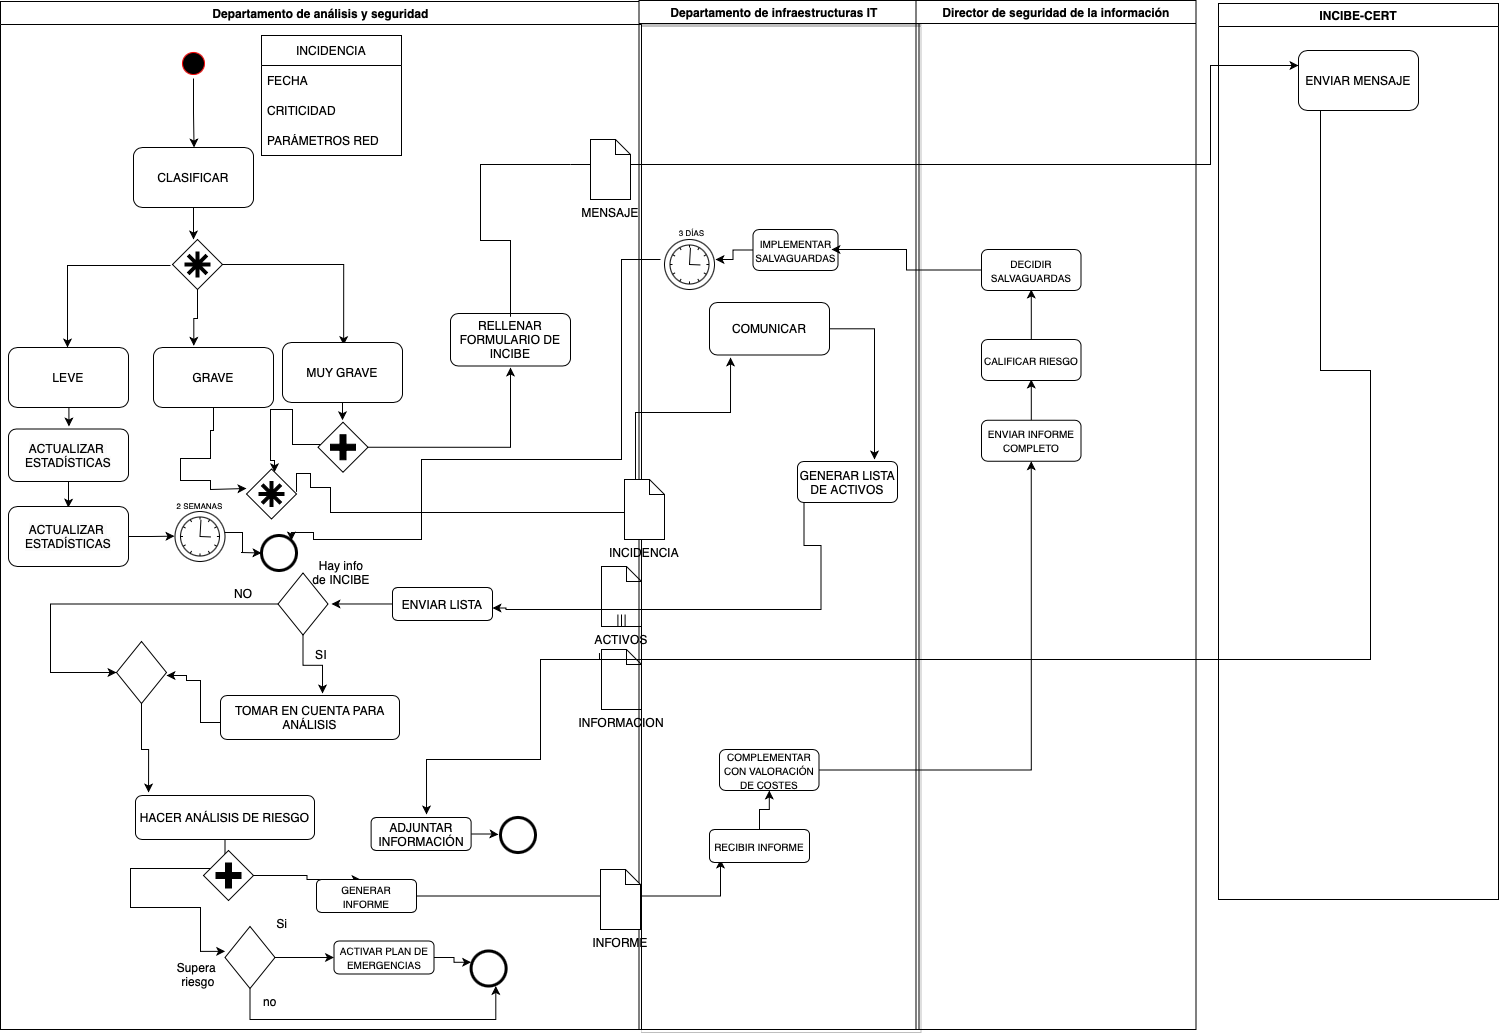

<br>

<h4>Antes de comenzar a resolver los ejercicios de análisis de datos, tendremos que hacer un modelo de base de datos. Este modelo va a ser creado en la siguiente función <code>createChartModel()</code>. Además importaremos algunas librerías que se usarán a lo largo del proyecto y crearemos unas variables globales que nos permiten generar la base de datos <code>pr1_SI.db</code> y conectarnos a ella y ejecutar consultas sobre esta.</h4>

In [10]:
!pip install pandas
!pip install sqlite3
!pip install json
!pip install matplotlib
!pip install numpy
############ Instalación e imports de liberías #################
import pandas as pd
import sqlite3
import json
import matplotlib.pyplot as plt
import numpy as np
#VARIABLES GLOBALES:
conexion= sqlite3.connect('pr1_SI.db')
cur=conexion.cursor()


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)
ERROR: No matching distribution found for sqlite3

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [9]:
def createChartModel():
    cur.execute("DROP TABLE IF EXISTS ALERTS")
    cur.execute("CREATE TABLE IF NOT EXISTS ALERTS (ID integer PRIMARY KEY autoincrement,TIME TIMESTAMP, SID INT, MSG TEXT, CLASIFICATION TEXT, PRIORITY INT,PROTOCOLO TEXT, ORIGEN TEXT, DESTINO TEXT, PUERTO INT)")
    cur.execute("CREATE TABLE if not exists RESPONSABLE (nombre text PRIMARY KEY, telefono int, rol text)")
    cur.execute("CREATE TABLE if not exists DEVICES (id text primary key , ip text, responsable_nombre text, localizacion text, FOREIGN KEY (responsable_nombre) references responsable(nombre))")
    cur.execute("CREATE TABLE if not exists ANALISIS (ID INTEGER PRIMARY KEY autoincrement, devices_id text UNIQUE, servicios int, servicios_ins int, detect_vulns int, FOREIGN KEY (devices_id) references DEVICES(id))")
    cur.execute("CREATE TABLE if not exists PUERTOS (id INTEGER PRIMARY KEY AUTOINCREMENT, nombre text,analisis_id int NOT NULL, FOREIGN KEY (analisis_id) REFERENCES ANALISIS(id) CONSTRAINT NOT_REPEATED_PORTS_ANALISIS UNIQUE (nombre, analisis_id))")

createChartModel()

*Como ALERTS.CSV tiene datos que pueden repetirse con mucha facilidad se borra la tabla y se inserta una sola vez la información, ya que pueden repetirse mensajes, protocolos, etc. En el resto de tablas hay constraints*
<br>Ahora insertamos la información en las tablas:


In [13]:
def insertInformationFromFiles():
    csvData=pd.read_csv("alerts.csv", sep=',', parse_dates=True)
    dataFrame=pd.DataFrame(csvData)
    for row in dataFrame.itertuples():
        cur.execute("INSERT INTO ALERTS (TIME, SID, MSG, CLASIFICATION, PRIORITY, PROTOCOLO, ORIGEN, DESTINO, PUERTO) VALUES (?,?,?,?,?,?,?,?,?)", (row[1], row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9]))
    print("Alerts.csv insertado con éxito en tabla ALERTS.\n\nInsertando devices.json en tablas del modelo:\n\n")
    with open("devices.json") as f:
        devices=json.load(f)
        print("Insertando responsables......")
        for i in devices:
           if i["responsable"]["telefono"]=="None":
               t=None
           else: ## Este bucle es pq si no inserta la frase NONE en lugar de meter null y para analizar es mas sencillo con Null (ademas none no es un dato valido).
               t = i["responsable"]["telefono"]
           if i["responsable"]["rol"]=="None":
               r=None
           else:
               r=i["responsable"]["rol"]
           cur.execute("INSERT OR IGNORE INTO RESPONSABLE (nombre, telefono, rol) VALUES (?,?,?)",(i["responsable"]["nombre"], t, r))

        b=cur.execute("SELECT COUNT(*) FROM RESPONSABLE").fetchall()
        print("....responsables insertados con éxito!!")
        print(str(b[0][0])+" responsables en la BBDD")
        print("Procedemos a insertar DEVICES!")
        for i in devices:
           loc=None if i["localizacion"]=="None" else i["localizacion"]
           cur.execute("INSERT OR IGNORE INTO DEVICES (id, IP, localizacion, responsable_nombre) VALUES (?,?,?,?)",(i["id"], i["ip"],loc,i["responsable"]["nombre"]))
        b = cur.execute("SELECT COUNT(*) FROM DEVICES").fetchall()
        print("....devices insertados con éxito!!")
        print(str(b[0][0]) + " devices en la BBDD")
        print("Procediendo a insertar ANÁLISIS.....")
        for i in devices:
            cur.execute("INSERT OR IGNORE INTO ANALISIS (DEVICES_ID, SERVICIOS, SERVICIOS_INS,DETECT_VULNS) VALUES (?,?,?,?)", (i["id"],i["analisis"]["servicios"],i["analisis"]["servicios_inseguros"], i["analisis"]["vulnerabilidades_detectadas"]))
        print("..... análisis insertados")
        b = cur.execute("SELECT COUNT(*) FROM DEVICES").fetchall()
        print(str(b[0][0])+" analisis en la BBDD")
    #Para insertar en la tabla puertos debemos ver qué puertos abiertos hay en X dispositivo y buscar su analisis_id en la BD
        for i in devices:
            print("Device id: " + i["id"])
            print("Analisis id: " + str(cur.execute("SELECT ID FROM ANALISIS WHERE DEVICES_ID=?", (i["id"],)).fetchall()[0][0]))
            print("Puertos abiertos: " + str(i["analisis"]["puertos_abiertos"]))
            analisis_id=cur.execute("SELECT ID FROM ANALISIS WHERE DEVICES_ID=?", (i["id"],)).fetchall()[0][0]
            for j in i["analisis"]["puertos_abiertos"]:
                if i["analisis"]["puertos_abiertos"]!="None":
                    name=j
                    print("nombre: " + name + " id analisis: " + str(analisis_id))
                    cur.execute("INSERT OR IGNORE INTO PUERTOS (NOMBRE, ANALISIS_ID) VALUES (?,?)",(name,analisis_id))
        print(".... puertos insertados correctamente!")


    conexion.commit()
    
insertInformationFromFiles()

Alerts.csv insertado con éxito en tabla ALERTS.

Insertando devices.json en tablas del modelo:


Insertando responsables......
....responsables insertados con éxito!!
4 responsables en la BBDD
Procedemos a insertar DEVICES!
....devices insertados con éxito!!
7 devices en la BBDD
Procediendo a insertar ANÁLISIS.....
..... análisis insertados
7 analisis en la BBDD
Device id: web
Analisis id: 1
Puertos abiertos: ['80/TCP', '443/TCP', '3306/TCP', '40000/UDP']
nombre: 80/TCP id analisis: 1
nombre: 443/TCP id analisis: 1
nombre: 3306/TCP id analisis: 1
nombre: 40000/UDP id analisis: 1
Device id: paco_pc
Analisis id: 2
Puertos abiertos: None
Device id: luis_pc
Analisis id: 3
Puertos abiertos: ['1194/UDP', '8080/TCP', '8080/UDP', '40000/UDP']
nombre: 1194/UDP id analisis: 3
nombre: 8080/TCP id analisis: 3
nombre: 8080/UDP id analisis: 3
nombre: 40000/UDP id analisis: 3
Device id: router1
Analisis id: 4
Puertos abiertos: ['443/UDP', '80/TCP']
nombre: 443/UDP id analisis: 4
nombre: 80/TCP id ana

<h3>Ejercicio 2</h3>
<h4 style='text-align: justify;'>El objetivo de este ejercicio será el de desarrollar un sencillo sistema ETL. No es necesario desarrollar las fases de extracción ya que disponemos de los archivos correspondientes. Debemos diseñar las tablas en la base de datos y desarrollar los códigos necesarios para leer los datos de los ficheros y almacenarlos en la base de datos. Después, será necesario leer los datos desde la BBDD (usando diferentes consultas) y se almacenarán los resultados en uno o varios DataFrames para poder manipularlos. En este ejercicio, para el correcto desarrollo del sistema, será necesario calcular los siguientes valores:<br>
<ul>
    <li>Número de dispositivos (y missing).</li>
    <li>Número de alertas.</li>
    <li>Media y desviación estándar del total de puertos abiertos.</li>
    <li>Media y desviación estándar del nuúmero de servicios inseguros detectados.</li>
    <li>Media y desviación estándar del número de vulnerabilidades detectadas.</li>
    <li>Valor mínimo y valor máximo del total de puertos abiertos.</li>
    <li>Valor mínimo y valor máximo del número de vulnerabilidades detectadas.</li>

</ul></h4>

In [14]:
def ejercicio2():
#1. Número de dispositivos
#Basando en IPs diferentes
    df=pd.read_sql_query("SELECT DISTINCT origen FROM ALERTS UNION SELECT DISTINCT destino FROM ALERTS ",conexion)
    print("Número de dispotivos = " + str(df.size) + " dispostivos")
    df=pd.read_sql_query("SELECT COUNT(*) NDEV FROM DEVICES", conexion)
    print("Tenemos " + str(df["NDEV"][0]) + " dispositivos conocidos")
    # como nos piden los none y los missing:

    df=pd.read_sql_query("select count(*) as MISSING_MSGS from ALERTS where msg like '%issing%'", conexion)
    print("Tenemos "+str(df["MISSING_MSGS"][0]) + " alertas con valores MISSING en sus mensajes")

    df1=pd.read_sql_query("SELECT * FROM DEVICES", conexion)
    df2=pd.read_sql_query("SELECT * FROM ANALISIS",conexion)
    df3=pd.read_sql_query("SELECT * FROM PUERTOS",conexion)
    df4=pd.read_sql_query("SELECT * FROM RESPONSABLE", conexion)

    print("Mostrando \"NONES\" del esquema generado desde devices.json:")
    print("TABLA DEVICES:")
    print(df1.isnull().sum(), end='\n\n')
    print("TABLA ANALISIS:")
    print(df2.isnull().sum(), end='\n\n')
    print("TABLA PUERTOS:")
    print(df3.isnull().sum(), end='\n\n')
    print("TABLA RESPONSABLES:")
    print(df4.isnull().sum(), end='\n\n')



    #2. Número de alertas

    df=pd.read_sql_query("SELECT sid FROM ALERTS ",conexion)
    print("Número de alertas = " + str(df.size) + " alertas")

    #3. Media y desviación estándar del totla de puertos abiertos
    #df=pd.read_sql_query("SELECT puerto FROM ALERTS ",conexion)

    #print("Media = " + str(df.mean()) )
    #print("Desviación estándar = " + str(df.std()))
    df=pd.read_sql_query("SELECT COUNT(*) P_ABIERTOS, ANALISIS_ID FROM PUERTOS GROUP BY ANALISIS_ID", conexion)
    print("El número medio de puertos abiertos en los dispositivos es: "+str(df["P_ABIERTOS"].mean())+" puertos.")
    print("La desviación estándar de puertos abiertos es : "+ str(round(df["P_ABIERTOS"].std(),2)))

    #4. Media y desviación est´andar del número de servicios inseguros detectados
    df=pd.read_sql_query("SELECT sum(SERVICIOS_INS) SERV_INSEGUROS, ID FROM ANALISIS GROUP BY ID", conexion)
    print("El número medio de servicios inseguros en los dispositivos es: "+str(round(df["SERV_INSEGUROS"].mean(),2))+" servicios.")
    print("La desviación estándar de servicios inseguros en los dispositivos es: "+str(round(df["SERV_INSEGUROS"].std(),2))+" servicios.")

    #5. Media y desviación estándar del número de vulnerabilidades detectadas.
    df=pd.read_sql_query("SELECT SUM(DETECT_VULNS) VULNS, ID FROM ANALISIS GROUP BY ID", conexion)
    print("El número medio de vulnerabilidades detectadas en los dispositivos es: "+str(round(df["VULNS"].mean(),2))+" vulnerabilidades.")
    print("La desviación estándar de vulnerabilidades detectadas en los dispositivos es: "+str(round(df["VULNS"].std(),2))+" vulnerabilidades.")


    #6. Valor mínimo y valor máximo del total de puertos abiertos. (Consulta un poco compleja por la estructura de la T puertos)
    df=pd.read_sql_query("SELECT MAX(PUERTOS_ABIERTOS), ANALISIS_ID FROM (SELECT COUNT(*) AS PUERTOS_ABIERTOS, ANALISIS_ID FROM PUERTOS GROUP BY ANALISIS_ID)", conexion)
    print("Como máximo hay "+ str(df["MAX(PUERTOS_ABIERTOS)"][0]) + " puertos abiertos correspondientes al id de análisis: " + str(df["ANALISIS_ID"][0])
          +" y al dispositivo: "+ str(pd.read_sql_query("SELECT ID FROM DEVICES WHERE ID= (SELECT DEVICES_ID FROM ANALISIS WHERE ID=?)",conexion, params=[str(df["ANALISIS_ID"][0])])["id"][0]))
    df=pd.read_sql_query("SELECT MIN(PUERTOS_ABIERTOS), ANALISIS_ID FROM (SELECT COUNT(*) AS PUERTOS_ABIERTOS, ANALISIS_ID FROM PUERTOS GROUP BY ANALISIS_ID)", conexion)
    print("Como mínimo hay "+ str(df["MIN(PUERTOS_ABIERTOS)"][0]) + " puertos abiertos correspondientes al id de análisis: " + str(df["ANALISIS_ID"][0]) +
        " y al dispositivo: "+ str(pd.read_sql_query("SELECT ID FROM DEVICES WHERE ID= (SELECT DEVICES_ID FROM ANALISIS WHERE ID=?)",conexion, params=[str(df["ANALISIS_ID"][0])])["id"][0]))


    #7. Valor mínimo y valor máximo del número de vulnerabilidades detectadas.
    df=pd.read_sql_query("SELECT DETECT_VULNS FROM ANALISIS", conexion)
    print("Podemos encontrar un mínimo de: " + str(df.min()[0])+" vulnerabilidades detectadas.")
    print("Podemos encontrar un máximo de: " + str(df.max()[0])+" vulnerabilidades detectadas.")

ejercicio2()

Número de dispotivos = 1666 dispostivos
Tenemos 7 dispositivos conocidos
Tenemos 2798 alertas con valores MISSING en sus mensajes
Mostrando "NONES" del esquema generado desde devices.json:
TABLA DEVICES:
id                    0
ip                    0
responsable_nombre    0
localizacion          4
dtype: int64

TABLA ANALISIS:
ID               0
devices_id       0
servicios        0
servicios_ins    0
detect_vulns     0
dtype: int64

TABLA PUERTOS:
id             0
nombre         0
analisis_id    0
dtype: int64

TABLA RESPONSABLES:
nombre      0
telefono    2
rol         1
dtype: int64

Número de alertas = 200225 alertas
El número medio de puertos abiertos en los dispositivos es: 3.5 puertos.
La desviación estándar de puertos abiertos es : 1.05
El número medio de servicios inseguros en los dispositivos es: 0.71 servicios.
La desviación estándar de servicios inseguros en los dispositivos es: 0.95 servicios.
El número medio de vulnerabilidades detectadas en los dispositivos es: 15.57 vu

<br>

<h3>Ejercicio 3</h3><h4 style='text-align: justify;'>Hay datos que nos interesa analizar en las alertas basándonos en agrupaciones, para darle un sentido a nuestro análisis en base a esa agrupación. De una manera más específica, vamos a trabajar con las siguientes agrupaciones:<br>
<ul>
    <li>Por prioridad de alerta (1 son alertas graves, 2 alertas medias y 3 alertas bajas).</li>
    <li>Fecha. Estableceremos dos rangos: El mes de julio y el mes de agosto.</li>
</ul>
<br>
En este caso deberemos calcular la siguiente información para la variable de vulnerabilidades detectadas en los dispositivos (Nota: en la alerta, el dispositivo puede ser el origen o el destino):
<ul>
    <li>Número de observaciones</li>
    <li>Número de valores ausentes (missing)</li>
    <li>Mediana</li>
    <li>Media</li>
    <li>Varianza</li>
    <li>Valores máximo y mínimo</li>
</ul>
</h4>

In [16]:
def ejercicio3():
    print("Ejercicio 3. Agrupamos según mes y según prioridad de alerta")
    #Agrupar de forma separada; por prioridad de alerta (1 al 3, de grave a leve), y por fechas (mes de julio o mes de agosto)
    #Según cada agrupación, mostrar con respecto a vulnerabilidades detectadas en los dispositivos (que puede ser origen o destino):
    df = pd.read_sql_query("SELECT STRFTIME('%Y-%m', time) AS year_month, COUNT(*) time, priority from alerts GROUP BY STRFTIME('%Y-%m', time), priority", conexion)
    #1. Número de observaciones
    print("Mes de Julio, número de alertas bajas: " + str(df["time"][0]))
    print("Mes de Julio, número de alertas medias: " + str(df["time"][1]))
    print("Mes de Julio, número de alertas altas: " + str(df["time"][2]))
    print("Mes de Agosto, número de alertas bajas: " + str(df["time"][3]))
    print("Mes de Agosto, número de alertas medias: " + str(df["time"][4]))
    print("Mes de Agosto, número de alertas altas: " + str(df["time"][5]))

    #2. Número de valores ausentes
    df=pd.read_sql_query("select count(*) as MISSING_MSGS, STRFTIME('%Y-%m', time) as year_month, priority from ALERTS where msg like '%issing%' group by priority, STRFTIME('%Y-%m', time)", conexion)
    print("Todos los valores ausentes encontrados son de prioridad 3")
    print("Mes de Julio, " +str(df["MISSING_MSGS"][0])+" valores ausentes encontrados")
    print("Mes de Agosto, " +str(df["MISSING_MSGS"][1])+" valores ausentes encontrados")

    #3. Mediana
    #Como el dispositivo puede ser el origen o el destino, se contará como vulnerabilidad detectada si aparece en la alerta en el origen o en el destino
    #Pero hay que seguir dividiendo entre mes de julio y agosto, y prioridades. Chequear el código
    df = pd.read_sql_query("select count(*)  as vulnPerDevice, origen from (select origen, STRFTIME('%Y-%m', time) as year_month, priority from alerts union all select destino, STRFTIME('%Y-%m', time) as year_month, priority from alerts) where year_month is '2022-07' or '2022-08' group by origen", conexion)
    datata = df.describe()
    print("Sobre los datos descubiertos de las vulnerabilidades según los dispositivos:")
    print("Mediana: " + str(int(datata["vulnPerDevice"][5])), end="\t")
    #4. Media
    print("Media: " + str(round(datata["vulnPerDevice"][1], 3)), end="\t")
    #5. Varianza
    print("Varianza: " + str(round(pow(datata["vulnPerDevice"][2], 2), 3)))
    #6. Máximo y mínimo
    print("Máximo: " + str(int(datata["vulnPerDevice"][7])), end="\t")
    print("Mínimo: " + str(int(datata["vulnPerDevice"][3])))
    #Falta imprimir estos valores agrupando por mes y por prioridad de alerta
    df = pd.read_sql_query("select count(*) as vulnPerDevice, origen, year_month, priority from(select origen, STRFTIME('%Y-%m', time) as year_month, priority from alerts union all select destino, STRFTIME('%Y-%m', time) as year_month, priority from alerts) where year_month is '2022-07' and priority is 1 group by origen, year_month", conexion)
    print("Sobre alertas en julio, con prioridad 1:")
    datata = df.describe()
    print("Mediana: " + str(int(datata["vulnPerDevice"][5])), end="\t")
    # 4. Media
    print("Media: " + str(round(datata["vulnPerDevice"][1], 3)), end="\t")
    # 5. Varianza
    print("Varianza: " + str(round(pow(datata["vulnPerDevice"][2], 2), 3)))
    # 6. Máximo y mínimo
    print("Máximo: " + str(int(datata["vulnPerDevice"][7])), end="\t")
    print("Mínimo: " + str(int(datata["vulnPerDevice"][3])))
    df = pd.read_sql_query(
        "select count(*) as vulnPerDevice, origen, year_month, priority from(select origen, STRFTIME('%Y-%m', time) as year_month, priority from alerts union all select destino, STRFTIME('%Y-%m', time) as year_month, priority from alerts) where year_month is '2022-07' and priority is 2 group by origen, year_month",
        conexion)
    print("Sobre alertas en julio, con prioridad 2:")
    datata = df.describe()
    print("Mediana: " + str(int(datata["vulnPerDevice"][5])), end="\t")
    # 4. Media
    print("Media: " + str(round(datata["vulnPerDevice"][1], 3)), end="\t")
    # 5. Varianza
    print("Varianza: " + str(round(pow(datata["vulnPerDevice"][2], 2), 3)))
    # 6. Máximo y mínimo
    print("Máximo: " + str(int(datata["vulnPerDevice"][7])), end="\t")
    print("Mínimo: " + str(int(datata["vulnPerDevice"][3])))
    df = pd.read_sql_query(
        "select count(*) as vulnPerDevice, origen, year_month, priority from(select origen, STRFTIME('%Y-%m', time) as year_month, priority from alerts union all select destino, STRFTIME('%Y-%m', time) as year_month, priority from alerts) where year_month is '2022-07' and priority is 3 group by origen, year_month",
        conexion)
    print("Sobre alertas en julio, con prioridad 3:")
    datata = df.describe()
    print("Mediana: " + str(int(datata["vulnPerDevice"][5])), end="\t")
    # 4. Media
    print("Media: " + str(round(datata["vulnPerDevice"][1], 3)), end="\t")
    # 5. Varianza
    print("Varianza: " + str(round(pow(datata["vulnPerDevice"][2], 2), 3)))
    # 6. Máximo y mínimo
    print("Máximo: " + str(int(datata["vulnPerDevice"][7])), end="\t")
    print("Mínimo: " + str(int(datata["vulnPerDevice"][3])))
    df = pd.read_sql_query(
        "select count(*) as vulnPerDevice, origen, year_month, priority from(select origen, STRFTIME('%Y-%m', time) as year_month, priority from alerts union all select destino, STRFTIME('%Y-%m', time) as year_month, priority from alerts) where year_month is '2022-08' and priority is 1 group by origen, year_month",
        conexion)
    print("Sobre alertas en agosto, con prioridad 1:")
    datata = df.describe()
    print("Mediana: " + str(int(datata["vulnPerDevice"][5])), end="\t")
    # 4. Media
    print("Media: " + str(round(datata["vulnPerDevice"][1], 3)), end="\t")
    # 5. Varianza
    print("Varianza: " + str(round(pow(datata["vulnPerDevice"][2], 2), 3)))
    # 6. Máximo y mínimo
    print("Máximo: " + str(int(datata["vulnPerDevice"][7])), end="\t")
    print("Mínimo: " + str(int(datata["vulnPerDevice"][3])))
    df = pd.read_sql_query(
        "select count(*) as vulnPerDevice, origen, year_month, priority from(select origen, STRFTIME('%Y-%m', time) as year_month, priority from alerts union all select destino, STRFTIME('%Y-%m', time) as year_month, priority from alerts) where year_month is '2022-08' and priority is 2 group by origen, year_month",
        conexion)
    print("Sobre alertas en julio, con prioridad 2:")
    datata = df.describe()
    print("Mediana: " + str(int(datata["vulnPerDevice"][5])), end="\t")
    # 4. Media
    print("Media: " + str(round(datata["vulnPerDevice"][1], 3)), end="\t")
    # 5. Varianza
    print("Varianza: " + str(round(pow(datata["vulnPerDevice"][2], 2), 3)))
    # 6. Máximo y mínimo
    print("Máximo: " + str(int(datata["vulnPerDevice"][7])), end="\t")
    print("Mínimo: " + str(int(datata["vulnPerDevice"][3])))
    df = pd.read_sql_query(
        "select count(*) as vulnPerDevice, origen, year_month, priority from(select origen, STRFTIME('%Y-%m', time) as year_month, priority from alerts union all select destino, STRFTIME('%Y-%m', time) as year_month, priority from alerts) where year_month is '2022-08' and priority is 3 group by origen, year_month",
        conexion)
    print("Sobre alertas en julio, con prioridad 3:")
    datata = df.describe()
    print("Mediana: " + str(int(datata["vulnPerDevice"][5])), end="\t")
    # 4. Media
    print("Media: " + str(round(datata["vulnPerDevice"][1], 3)), end="\t")
    # 5. Varianza
    print("Varianza: " + str(round(pow(datata["vulnPerDevice"][2], 2), 3)))
    # 6. Máximo y mínimo
    print("Máximo: " + str(int(datata["vulnPerDevice"][7])), end="\t")
    print("Mínimo: " + str(int(datata["vulnPerDevice"][3])))
ejercicio3()

Ejercicio 3. Agrupamos según mes y según prioridad de alerta
Mes de Julio, número de alertas bajas: 962
Mes de Julio, número de alertas medias: 3612
Mes de Julio, número de alertas altas: 6916
Mes de Agosto, número de alertas bajas: 1371
Mes de Agosto, número de alertas medias: 2703
Mes de Agosto, número de alertas altas: 183687
Todos los valores ausentes encontrados son de prioridad 3
Mes de Julio, 1315 valores ausentes encontrados
Mes de Agosto, 1365 valores ausentes encontrados
Sobre los datos descubiertos de las vulnerabilidades según los dispositivos:
Mediana: 3	Media: 240.366	Varianza: 86219207.315
Máximo: 378998	Mínimo: 1
Sobre alertas en julio, con prioridad 1:
Mediana: 3	Media: 23.181	Varianza: 23397.052
Máximo: 1387	Mínimo: 1
Sobre alertas en julio, con prioridad 2:
Mediana: 1	Media: 7.878	Varianza: 14113.618
Máximo: 3563	Mínimo: 1
Sobre alertas en julio, con prioridad 3:
Mediana: 2	Media: 15.772	Varianza: 44817.359
Máximo: 6036	Mínimo: 1
Sobre alertas en agosto, con priorida

<br>

<h3>Ejercicio 4</h3>
<h4 style='text-align: justify;'>Por último, se programarán las diferentes funciones del MIS. En concreto, se deben generar gráficos sencillos para obtener los siguientes datos:<br>
    <ul>
        <li>Mostrar las 10 IP de origen más problemáticas, representadas en un gráfico de barras (las IPs de origen más problemáticas son las que más alertas han generado con prioridad 1).</li>
        <li>Número de alertas en el tiempo, representadas en una serie temporal.</li>
        <li>Número de alertas por categoría, representadas en un gráfico de barras.</li>
        <li>Dispositivos más vulnerables (Suma de servicios vulnerables y vulnerabilidades detectadas).</li>
        <li>Media de puertos abiertos frente a servicios inseguros y frente al total de servicios detectados.</li>
    
    
    
</h4>

In [ ]:
def ejercicio4(): #Falta el ultimo apartado.
    #1. Mostrar las 10 IP de origen más problemáticas, representadas en un gráfico de barras (las IPs de origen más problemáticas son las que más alertas han generado con prioridad 1).
    #df=pd.read_sql_query("SELECT COUNT(*) as num, origen FROM ALERTS WHERE priority = 1 GROUP BY origen ORDER BY num desc",conexion)
    df=pd.read_sql_query("SELECT COUNT(*) as num, origen AS origen FROM ALERTS WHERE priority = 1 GROUP BY origen ORDER BY num desc",conexion)
    muestra=df[:10].copy()
    x_values=muestra['origen']
    y_values=muestra['num']
    plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.bar(x_values,y_values)
    plt.show()
    plt.close("all")
    #2. Número de alertas en el tiempo, representadas en una serie temporal.
    df=pd.read_sql_query("SELECT time as time FROM ALERTS ",conexion)
    df.index=df['time']
    print(df)
    #3. Número de alertas por categoría, representadas en un gráfico de barras.
    df=pd.read_sql_query("SELECT COUNT(*) as num, clasification FROM ALERTS GROUP BY clasification ORDER BY num desc ",conexion)
    print(df)
    plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    x_values=['GPCD','MA','PBT','NST','PCPV','AIL','AAPG','DNS','WAA','NT','APVWA','AUPG','IL','ma']
    #df['clasification']
    y_values=df['num']
    plt.bar(x_values,y_values)
    plt.show()
    plt.close("all")

    #4. Dispositivos más vulnerables (Suma de servicios vulnerables y vulnerabilidades detectadas).
    df=pd.read_sql_query("SELECT (DETECT_VULNS+SERVICIOS_INS) suma, DEVICES_ID devices_id FROM ANALISIS", conexion)
    print(df)
    plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    x_values=df["devices_id"]
    y_values=df["suma"]
    plt.bar(x_values, y_values)
    plt.show()
    plt.close("all")
    #5. Media de puertos abiertos frente a servicios inseguros y frente al total de servicios detectados.

ejercicio4()


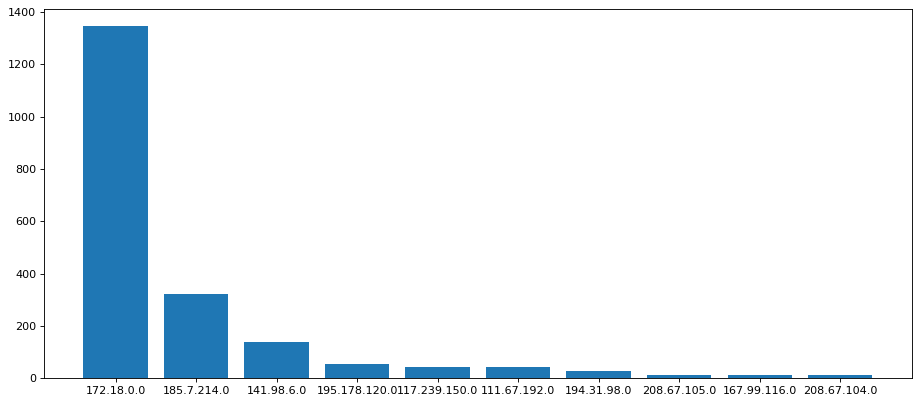

                                    time
time                                    
2022-07-03 00:19:55  2022-07-03 00:19:55
2022-07-03 00:49:22  2022-07-03 00:49:22
2022-07-03 00:49:22  2022-07-03 00:49:22
2022-07-03 00:49:22  2022-07-03 00:49:22
2022-07-03 00:50:30  2022-07-03 00:50:30
...                                  ...
2022-09-05 04:44:37  2022-09-05 04:44:37
2022-09-05 04:44:37  2022-09-05 04:44:37
2022-09-05 05:39:31  2022-09-05 05:39:31
2022-09-05 05:39:31  2022-09-05 05:39:31
2022-09-05 05:50:56  2022-09-05 05:50:56

[200225 rows x 1 columns]
       num                                      CLASIFICATION
0   188985                    Generic Protocol Command Decode
1     3505                                        Misc Attack
2     1950                            Potentially Bad Traffic
3     1692                             Not Suspicious Traffic
4     1378              Potential Corporate Privacy Violation
5      978                         Attempted Information Leak
6     

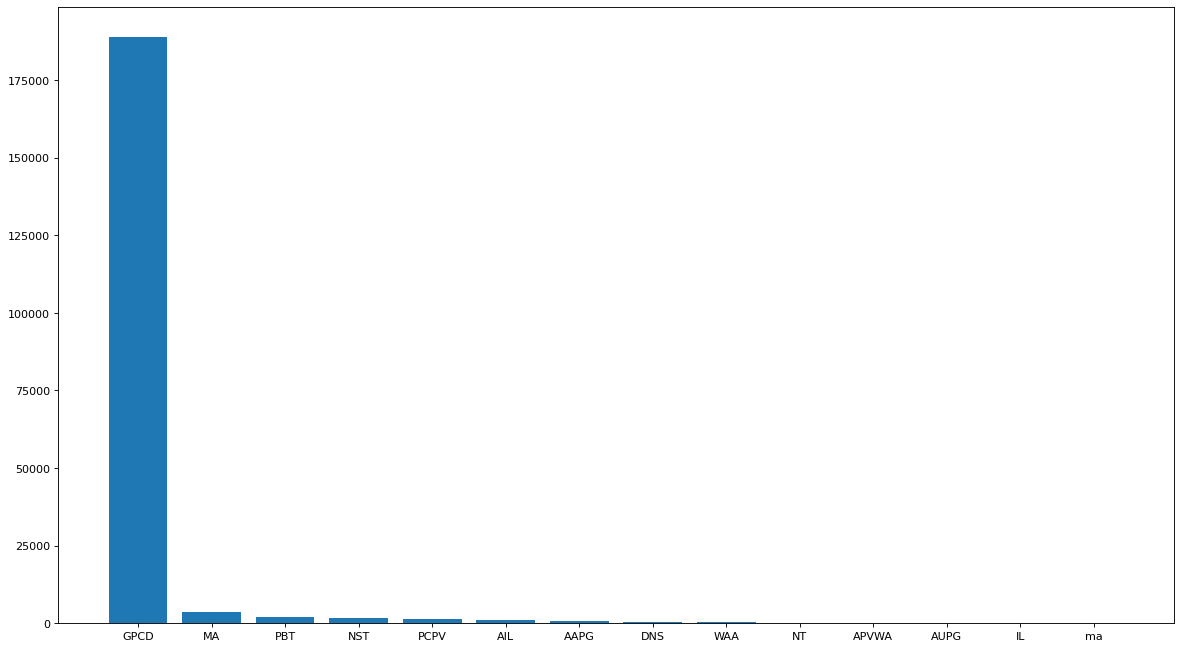

   suma   devices_id
0    15          web
1     4      paco_pc
2    53      luis_pc
3     3      router1
4    14  dhcp_server
5     2     mysql_db
6    23          ELK


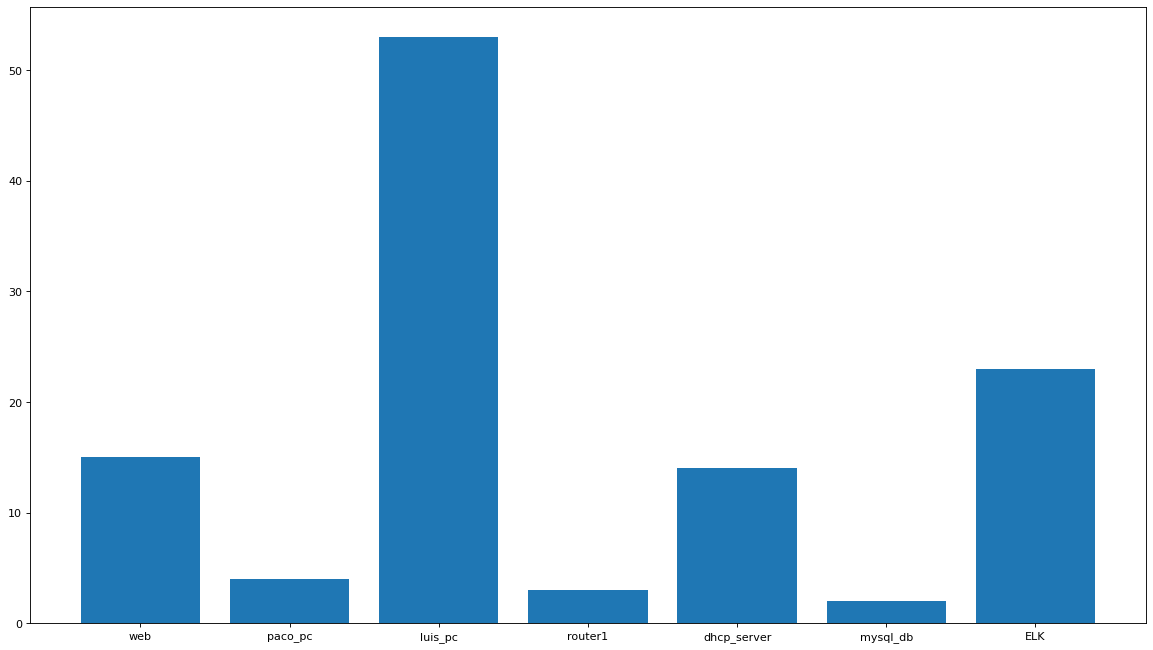

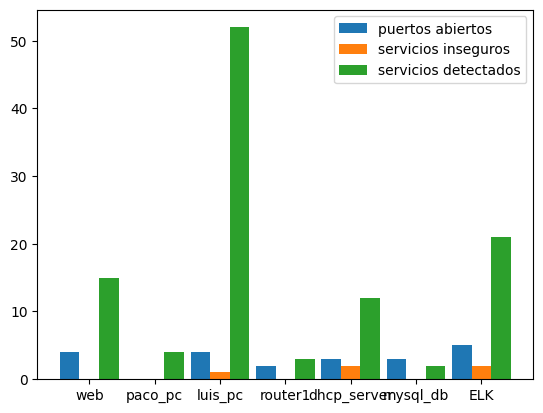

In [18]:
def ejercicio4(): #Falta el ultimo apartado.
    #1. Mostrar las 10 IP de origen más problemáticas, representadas en un gráfico de barras (las IPs de origen más problemáticas son las que más alertas han generado con prioridad 1).
    #df=pd.read_sql_query("SELECT COUNT(*) as num, origen FROM ALERTS WHERE priority = 1 GROUP BY origen ORDER BY num desc",conexion)
    df=pd.read_sql_query("SELECT COUNT(*) as num, origen AS origen FROM ALERTS WHERE priority = 1 GROUP BY origen ORDER BY num desc",conexion)
    muestra=df[:10].copy()
    x_values=muestra['origen']
    y_values=muestra['num']
    plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.bar(x_values,y_values)
    plt.show()
    plt.close("all")
    #2. Número de alertas en el tiempo, representadas en una serie temporal.
    df=pd.read_sql_query("SELECT time as time FROM ALERTS ",conexion)
    df.index=df['time']
    print(df)
    #3. Número de alertas por categoría, representadas en un gráfico de barras.
    df=pd.read_sql_query("SELECT COUNT(*) as num, clasification FROM ALERTS GROUP BY clasification ORDER BY num desc ",conexion)
    print(df)
    plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    x_values=['GPCD','MA','PBT','NST','PCPV','AIL','AAPG','DNS','WAA','NT','APVWA','AUPG','IL','ma']
    #df['clasification']
    y_values=df['num']
    plt.bar(x_values,y_values)
    plt.show()
    plt.close("all")

    #4. Dispositivos más vulnerables (Suma de servicios vulnerables y vulnerabilidades detectadas).
    df=pd.read_sql_query("SELECT (DETECT_VULNS+SERVICIOS_INS) suma, DEVICES_ID devices_id FROM ANALISIS", conexion)
    print(df)
    plt.figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    x_values=df["devices_id"]
    y_values=df["suma"]
    plt.bar(x_values, y_values)
    plt.show()
    plt.close("all")
    #5. Media de puertos abiertos frente a servicios inseguros y frente al total de servicios detectados.
    # Consideramos que "frente" se refiere a proporción?
    # Media o número de puertos abiertos por dispositivo ?

    df1=pd.read_sql_query("SELECT ID,devices_id, servicios_ins,detect_vulns FROM ANALISIS", conexion)
    df2= pd.read_sql_query("SELECT COUNT(*) P_ABIERTOS, ANALISIS_ID as ID FROM PUERTOS GROUP BY ANALISIS_ID", conexion)
    df=pd.merge(left=df1,right=df2,left_on='ID',right_on='ID',how = 'outer')
    df.index = df1['devices_id']
    n=len(df['devices_id'])
    x=np.arange(n)
    width=0.3
    plt.bar(x-width, df['P_ABIERTOS'], width=width, label="puertos abiertos")
    plt.bar(x,df['servicios_ins'],width=width,label="servicios inseguros")
    plt.bar(x+width,df['detect_vulns'],width=width,label="servicios detectados")

    plt.xticks(x,df.index)
    plt.legend(loc='best')
    plt.show()
    plt.close("all")

ejercicio4()